In [13]:
import datetime
# import pandas_datareader.data as web
# import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tushare as ts

import mpl_finance as mpf

ModuleNotFoundError: No module named 'tushare'

In [104]:
# def getData(stc, start, end, source='yahoo'):
#     data = web.DataReader(stc, source, start, end)
#     return data


# start = datetime.datetime(2017,10,1)
# end = datetime.datetime(2018,12,31)
# stc = 'GOOG'
# data = getData(stc, start, end)


In [105]:
def getBand(data, timeperiod=20, deviation=2):
    band = pd.DataFrame(index=data.index)
    band['Adj Close'] = data['Adj Close']
    band['Open'] = data['Open']
    band['MA20'] = data['Adj Close'].rolling(window=20).mean()
    band['dev'] = data['Adj Close'].rolling(window=20).std()
    band['upper_band'] = band['MA20'] + deviation*band['dev']
    band['lower_band'] = band['MA20'] - deviation*band['dev']
    
    band = band.dropna(axis=0, how='any')
    
#     band.loc['2018'][['Adj Close','upper_band','MA20','lower_band']].plot(figsize=(17,10))
#     plt.ylim(min(band['lower_band'])-100)
#     plt.show()

    
    
    # dev and devchange for future improvement on signals
    
    band['devchange'] = band['dev'] - band['dev'].shift(1)  # i+1-i
    
    
    
    return band
    
    

band = getBand(data)
band.head()




,Adj Close,Open,MA20,dev,upper_band,lower_band,devchange
Date,,,,,,,
2017-10-27,1019.270020,1009.190002,979.087003,15.907393,1010.901789,947.272216,NaN
2017-10-30,1017.109985,1014.000000,982.279001,16.832474,1015.943949,948.614052,0.925081
2017-10-31,1016.640015,1015.219971,985.221503,17.458390,1020.138283,950.304723,0.625916
2017-11-01,1025.500000,1017.210022,988.912503,17.794096,1024.500695,953.324312,0.335706
2017-11-02,1025.579956,1021.760010,991.693500,18.982809,1029.659118,953.727882,1.188713


,Buy,Sell
Date,,
2017-10-27,None,None
2017-10-30,None,None
2017-10-31,None,1
2017-11-01,None,None
2017-11-02,None,1


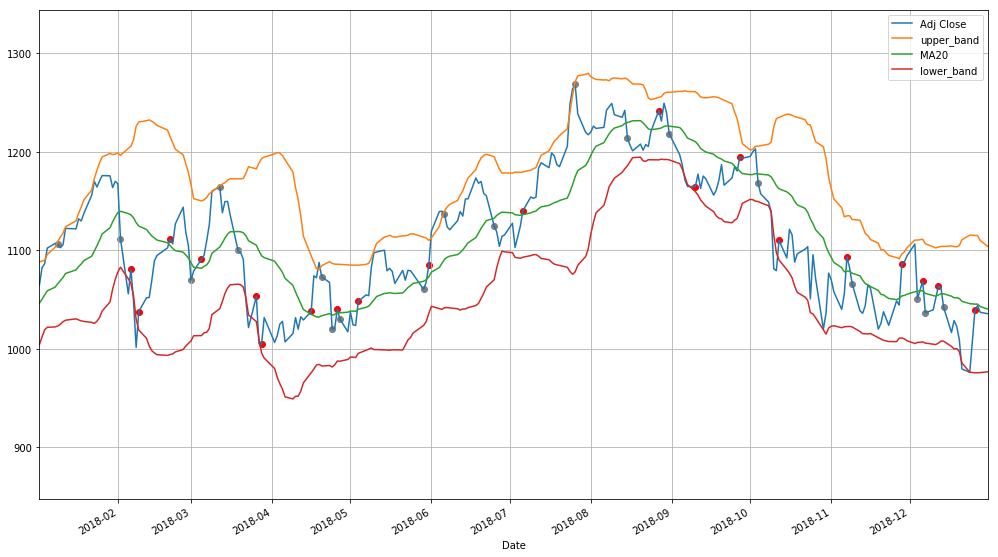

In [106]:
def getSignal(band):
    
    signals = pd.DataFrame(index=band.index)
    signals['Buy'] = None
    signals['Sell'] = None
    
#Four common rules

#     signals.loc[(band['Close'] < band['lower_band']), 'Buy'] = 1
#     signals.loc[(band['Close'] > band['upper_band']), 'Sell'] = 1

    signals.loc[(band['Adj Close'] > band['MA20']) & (band['Adj Close'].shift(1) < band['MA20'].shift(1)), 'Buy'] = 1
    signals.loc[(band['Adj Close'] < band['MA20']) & (band['Adj Close'].shift(1) > band['MA20'].shift(1)), 'Sell'] = 1
    signals.loc[(band['Adj Close'] > band['lower_band']) & (band['Adj Close'].shift(1) < band['lower_band'].shift(1)), 'Buy'] = 1
    signals.loc[(band['Adj Close'] < band['upper_band']) & (band['Adj Close'].shift(1) > band['upper_band'].shift(1)), 'Sell'] = 1
    
#     signals.loc[signals.index[0], 'Position'] = 0
#     signals.loc[signals['Buy'].shift(1) == 1, 'Position'] = 1
#     signals.loc[signals['Sell'].shift(1) == 1, 'Position'] = 0
#     signals['Position'].fillna(method='ffill', inplace=True)
    
    
#plot
    band.loc['2018'][['Adj Close','upper_band','MA20','lower_band']].plot(figsize=(17,10))
    plt.scatter(band.index, band['Adj Close']*(signals['Buy']==1), color='red')
    plt.scatter(band.index, band['Adj Close']*(signals['Sell']==1), color='grey')
    plt.grid()
    plt.ylim(min(band['lower_band'])-100)
    
    

#Improvements
#Using dev to determine signal
#Consider holddays and stop loss rule
    
    return signals

signal = getSignal(band)


band.head()
signal.head()

In [107]:
def BackTest(signal, band, cash=5000000, shares=100000, per1=0.5, per2=0.6, se=1.05, sl=0.9):
    
    portfolio = band
    portfolio['Buy'] = signal['Buy']
    portfolio['Sell'] = signal['Sell']
    portfolio['value'] = cash + shares*band['Adj Close'][0] 
    portfolio['cash'] = cash  
    portfolio['holding'] =  shares*band['Adj Close'][0] 
    portfolio['position'] = shares 
    
    threshold = cash + shares*band['Adj Close'][0]
    
    portfolio = portfolio.reset_index()
    
    for i in portfolio.index[:-1]:
        if portfolio.iloc[i, 8]==1:
            portfolio.iloc[i+1, 13] = portfolio.iloc[i, 13] + portfolio.iloc[i, 11]*per1/portfolio.iloc[i+1, 2]
            portfolio.iloc[i+1, 12] = portfolio.iloc[i+1, 13]*portfolio.iloc[i+1, 1]
            portfolio.iloc[i+1, 11] = portfolio.iloc[i, 11]*(1-per1)
            portfolio.iloc[i+1, 10] = portfolio.iloc[i+1, 11] + portfolio.iloc[i+1, 12]
            threshold = portfolio.iloc[i+1, 12]
            
        elif portfolio.iloc[i, 9]==1:
            portfolio.iloc[i+1, 13] = portfolio.iloc[i, 13]*(1-per2)
            portfolio.iloc[i+1, 12] = portfolio.iloc[i+1, 13]*portfolio.iloc[i+1, 1]
            portfolio.iloc[i+1, 11] = portfolio.iloc[i, 11] + portfolio.iloc[i, 13]*per2*portfolio.iloc[i+1, 2]
            portfolio.iloc[i+1, 10] = portfolio.iloc[i+1, 11] + portfolio.iloc[i+1, 12]
            threshold = portfolio.iloc[i+1, 12]
        else:
            portfolio.iloc[i+1, 13] = portfolio.iloc[i, 13]
            portfolio.iloc[i+1, 12] = portfolio.iloc[i+1, 13]*portfolio.iloc[i+1, 1]
            portfolio.iloc[i+1, 11] = portfolio.iloc[i, 11]
            portfolio.iloc[i+1, 10] = portfolio.iloc[i+1, 11] + portfolio.iloc[i+1, 12]
            if portfolio.iloc[i+1, 12]>(se*threshold):
                portfolio.iloc[i+1, 8]=0
                portfolio.iloc[i+1, 9]=1
            if portfolio.iloc[i+1, 12]<(sl*threshold):
                portfolio.iloc[i+1, 9]=1
                portfolio.iloc[i+1, 8]=0
            
            
        portfolio['position change'] = portfolio['position'] - portfolio['position'].shift(1)
        portfolio['cash flow'] = portfolio['cash'] - portfolio['cash'].shift(1)
        portfolio['realized return'] = (portfolio['value'] - portfolio['value'][0])/portfolio['value'][0]
        
    
    return portfolio


portfolio = BackTest(signal, band)
print(sum(portfolio['position change']!=0))
portfolio



50


,Date,Adj Close,Open,MA20,dev,upper_band,lower_band,devchange,Buy,Sell,value,cash,holding,position,position change,cash flow,realized return
0,2017-10-27,1019.270020,1009.190002,979.087003,15.907393,1010.901789,947.272216,NaN,None,None,1.069270e+08,5.000000e+06,1.019270e+08,100000.000000,NaN,NaN,0.000000
1,2017-10-30,1017.109985,1014.000000,982.279001,16.832474,1015.943949,948.614052,0.925081,None,None,1.067110e+08,5.000000e+06,1.017110e+08,100000.000000,0.000000,0.000000e+00,-0.002020
2,2017-10-31,1016.640015,1015.219971,985.221503,17.458390,1020.138283,950.304723,0.625916,None,1,1.066640e+08,5.000000e+06,1.016640e+08,100000.000000,0.000000,0.000000e+00,-0.002460
3,2017-11-01,1025.500000,1017.210022,988.912503,17.794096,1024.500695,953.324312,0.335706,None,None,1.070526e+08,6.603260e+07,4.102000e+07,40000.000000,-60000.000000,6.103260e+07,0.001175
4,2017-11-02,1025.579956,1021.760010,991.693500,18.982809,1029.659118,953.727882,1.188713,None,1,1.070558e+08,6.603260e+07,4.102320e+07,40000.000000,0.000000,0.000000e+00,0.001205
5,2017-11-03,1032.479980,1022.109985,994.372998,20.777781,1035.928560,952.817436,1.794972,None,None,1.070829e+08,9.056324e+07,1.651968e+07,16000.000000,-24000.000000,2.453064e+07,0.001458
6,2017-11-06,1025.900024,1028.989990,996.817999,21.490731,1039.799462,953.836537,0.712950,None,None,1.069776e+08,9.056324e+07,1.641440e+07,16000.000000,0.000000,0.000000e+00,0.000474
7,2017-11-07,1033.329956,1027.270020,999.854498,22.168473,1044.191445,955.517552,0.677742,None,None,1.070965e+08,9.056324e+07,1.653328e+07,16000.000000,0.000000,0.000000e+00,0.001585
8,2017-11-08,1039.849976,1030.520020,1002.384497,23.727119,1049.838736,954.930258,1.558646,None,None,1.072008e+08,9.056324e+07,1.663760e+07,16000.000000,0.000000,0.000000e+00,0.002561
9,2017-11-09,1031.260010,1033.989990,1004.555997,24.305297,1053.166591,955.945402,0.578178,None,None,1.070634e+08,9.056324e+07,1.650016e+07,16000.000000,0.000000,0.000000e+00,0.001276


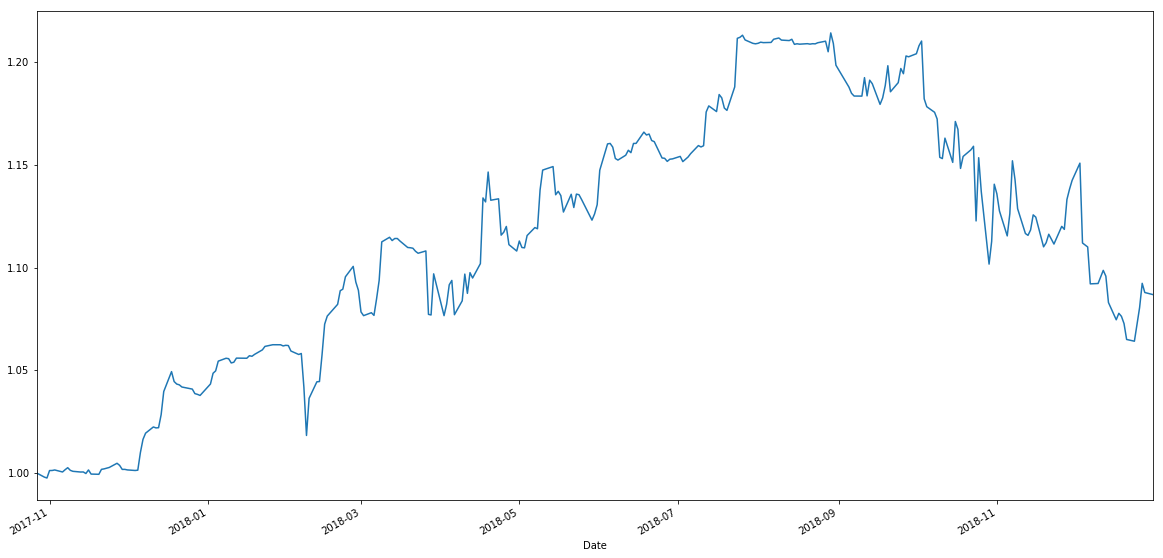

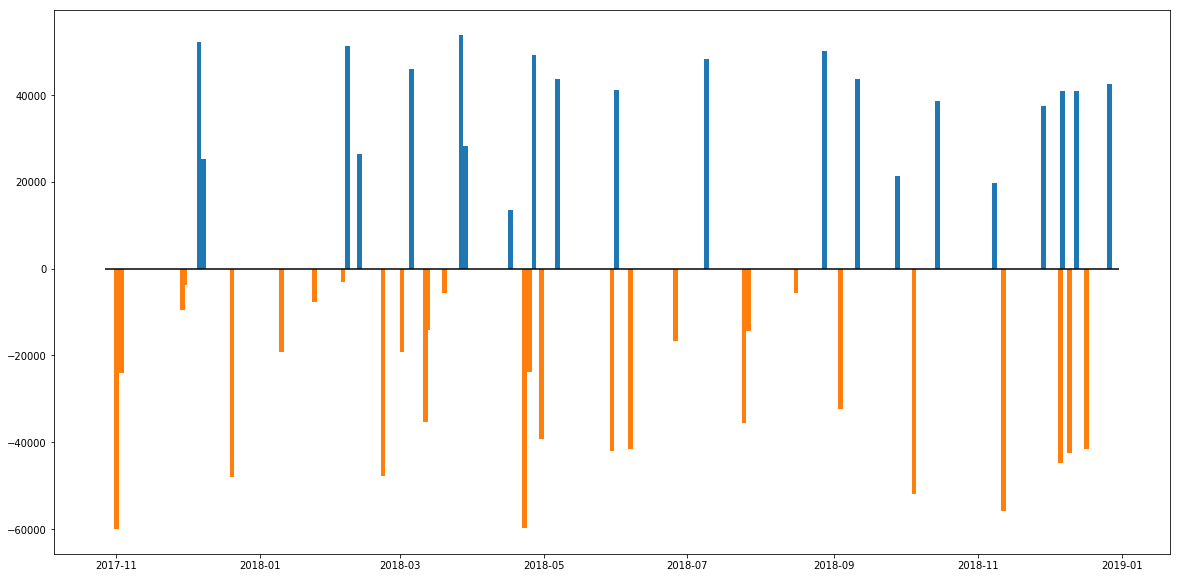

In [108]:
def getPlot(portfoliop):
    
    portfoliop = portfolio.set_index(['Date'])
    plt.figure(11, figsize=(20, 10))
    (portfoliop['value']/portfoliop['value'][0]).plot()
    plt.show()
    plt.figure(11, figsize=(20, 10))
    plt.bar(portfoliop[portfoliop['position change']>0].index, portfoliop[portfoliop['position change']>0]['position change'], width=2)
    plt.bar(portfoliop[portfoliop['position change']<0].index, portfoliop[portfoliop['position change']<0]['position change'], width=2)
    plt.hlines(0, min(portfoliop.index), max(portfoliop.index), color='black')
    plt.show()

getPlot(portfolio)

In [109]:
signal = portfolio[['Date', 'position change']]
signal = signal.rename(columns={'position change':'Shares'})
signal = signal[signal['Shares']!=0].dropna()
print(len(signal))
signal.head()
signal.to_csv('BB_signal.csv', index=False)

49


In [110]:
# ts.get_tick_data('AAPL', '2018-09-04')

In [111]:
# !pip install alpha_vantage

In [112]:
# from alpha_vantage.timeseries import TimeSeries

In [113]:
# ts = TimeSeries(key='9AMR2903VMD8PK5E',output_format='pandas')

In [114]:
# data, metadata = ts.get_intraday(symbol='AAPL',interval='1min', outputsize='full')

In [115]:
# data